# Loop Hydrodynamics: Bundle Heating Model
Run EBTEL simulations for the bundle heating model

In [1]:
import os
import sys
import subprocess
import multiprocessing

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import synthesizAR
from synthesizAR.interfaces import EbtelInterface

sys.path.append('../../scripts/')
from bundle_heating_model import BundleHeatingModel

%matplotlib inline

In [2]:
noaa1158 = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

In [3]:
heating_options = {
    'stress': 5e-3,
    'event_duration': 200 * u.s,
    'storm_duration': 500. * u.s
}
num_bins = 50

In [4]:
heating_model = BundleHeatingModel(heating_options, noaa1158, num_bins=num_bins,)

FloatProgress(value=0.0)

In [5]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-8
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [6]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/hydro_config/',
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/hydro_results/')

In [7]:
heating_model.constrain_number_storms(base_config['total_time']*u.s)

Error = 1.0736422482980066, phi = 2.0736422482980066, n_storms = 50
Error = 0.2321203246500415, phi = 0.7678796753499585, n_storms = 61
Error = 0.08992717959121299, phi = 0.910072820408787, n_storms = 66
Error = 0.34023886180862517, phi = 1.3402388618086252, n_storms = 43
Error = 0.17937312787324944, phi = 0.8206268721267506, n_storms = 50
Error = 0.0973988165855676, phi = 0.9026011834144324, n_storms = 54
Error = 0.06458308884228159, phi = 1.0645830888422816, n_storms = 50
Error = 0.23800890791459828, phi = 0.7619910920854017, n_storms = 61
Error = 0.22592955067335696, phi = 1.225929550673357, n_storms = 47
Error = 0.008059810641260379, phi = 0.9919401893587396, n_storms = 47


In [8]:
noaa1158.configure_loop_simulations(ebtel_interface)

FloatProgress(value=0.0)

In [9]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [10]:
pool = multiprocessing.Pool()

In [11]:
runs = pool.map_async(ebtel_runner,noaa1158.loops)
runs.wait()

In [13]:
noaa1158.load_loop_simulations(ebtel_interface,
                            savefile='/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/loop_parameters.h5'
                           )

FloatProgress(value=0.0)

Text(0.5,0,'$t$ [s]')

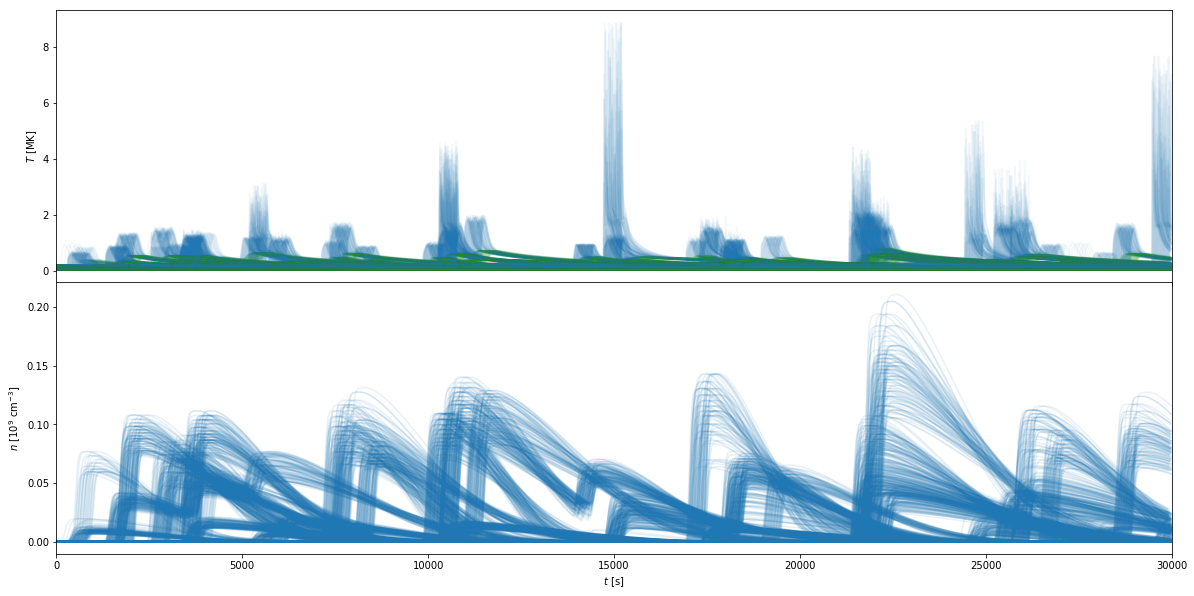

In [16]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in noaa1158.loops[::]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.05)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim(0,base_config['total_time'])
#axes[0].set_ylim(0,20)
#axes[1].set_ylim(0,20)
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [17]:
noaa1158.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/field_checkpoint')